Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

First reload the data we generated in `1_notmnist.ipynb`.

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (50000, 28, 28) (50000,)
Validation set (1000, 28, 28) (1000,)
Test set (1000, 28, 28) (1000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (50000, 784) (50000, 10)
Validation set (1000, 784) (1000, 10)
Test set (1000, 784) (1000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

Let's start with the logistic model:

In [5]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  beta_regul = tf.placeholder(tf.float32)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)) + beta_regul * tf.nn.l2_loss(weights)
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [6]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : 1e-3}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 17.940277
Minibatch accuracy: 11.7%
Validation accuracy: 13.9%
Minibatch loss at step 500: 2.865490
Minibatch accuracy: 71.9%
Validation accuracy: 74.0%
Minibatch loss at step 1000: 1.713219
Minibatch accuracy: 78.1%
Validation accuracy: 76.7%
Minibatch loss at step 1500: 1.213735
Minibatch accuracy: 82.0%
Validation accuracy: 78.8%
Minibatch loss at step 2000: 0.979322
Minibatch accuracy: 81.2%
Validation accuracy: 79.4%
Minibatch loss at step 2500: 0.705286
Minibatch accuracy: 83.6%
Validation accuracy: 80.4%
Minibatch loss at step 3000: 0.602646
Minibatch accuracy: 84.4%
Validation accuracy: 80.6%
Test accuracy: 88.9%


The L2 regularization introduces a new meta parameter that should be tuned. Since I do not have any idea of what should be the right value of this meta parameter, I will plot the accuracy by the meta parameter value (in a logarithmic scale)

In [7]:
num_steps = 3001
regul_val = [pow(10,i) for i in np.arange(-4, -2, 0.1)]
accuracy_val = []

for regul in regul_val:
    with tf.Session(graph=graph) as session:
      tf.global_variables_initializer().run()
      for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : regul}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
      accuracy_val.append(accuracy(test_prediction.eval(), test_labels))
        
     

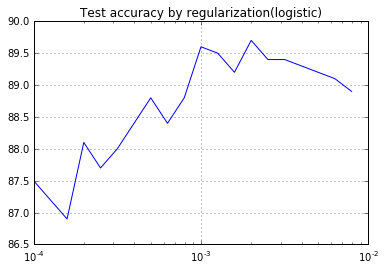

In [8]:
import matplotlib.pyplot as plt
plt.semilogx(regul_val, accuracy_val)
plt.grid(True)
plt.title('Test accuracy by regularization(logistic)')
plt.show()

Let's see if the same technique will improve the prediction of the 1 layer neural network

In [9]:
batch_size = 128
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():
    
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch
    tf_train_dataset = tf.placeholder(tf.float32,
                                     shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_regul = tf.placeholder(tf.float32)
    
    # Variables
    weights1 = tf.Variable(
      tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
    biases1 = tf.Variable(tf.zeros([num_hidden_nodes]))
    weights2 = tf.Variable(
      tf.truncated_normal([num_hidden_nodes, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))
    
    # Training Computation
    lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    logits = tf.matmul(lay1_train, weights2) + biases2
    loss = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = tf_train_labels)) + \
        beta_regul * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2))
      
    # Optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Predictions for training, validation and test data
    train_prediction = tf.nn.softmax(logits)
    lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    valid_prediction = tf.nn.softmax(tf.matmul(lay1_valid, weights2) + biases2)
    lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights2) + biases2)
    

In [10]:
num_steps = 3001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        # Pick an offset within the training data , which has been randomized.
        # Note: we could use better randomization across epochs
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, beta_regul : 1e-3}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict = feed_dict)
        if (step % 500)==0:
            print('Minibatch loss at step %d: %f' % (step,l))
            print('Minibatch accuracy: %.lf%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.lf%%' % accuracy(
                valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.lf%%' % accuracy(test_prediction.eval(), test_labels))
    

Initialized
Minibatch loss at step 0: 724.376160
Minibatch accuracy: 7%
Validation accuracy: 31%
Minibatch loss at step 500: 196.505783
Minibatch accuracy: 83%
Validation accuracy: 77%
Minibatch loss at step 1000: 116.186966
Minibatch accuracy: 84%
Validation accuracy: 80%
Minibatch loss at step 1500: 69.093033
Minibatch accuracy: 86%
Validation accuracy: 82%
Minibatch loss at step 2000: 41.543285
Minibatch accuracy: 95%
Validation accuracy: 83%
Minibatch loss at step 2500: 25.305973
Minibatch accuracy: 95%
Validation accuracy: 86%
Minibatch loss at step 3000: 15.477118
Minibatch accuracy: 95%
Validation accuracy: 86%
Test accuracy: 93%


In [16]:
num_steps = 3001
regul_val = [pow(10,i) for i in np.arange(-4, -2, 0.1)]
accuracy_val = []

for regul in regul_val:
    with tf.Session(graph=graph) as session:
      tf.global_variables_initializer().run()
      for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, beta_regul : regul}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
      accuracy_val.append(accuracy(test_prediction.eval(), test_labels))
        
     

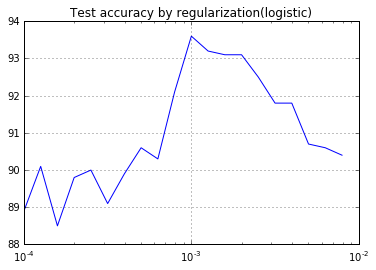

In [17]:
import matplotlib.pyplot as plt
plt.semilogx(regul_val, accuracy_val)
plt.grid(True)
plt.title('Test accuracy by regularization(logistic)')
plt.show()

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [18]:
batch_size = 128
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():
    
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch
    tf_train_dataset = tf.placeholder(tf.float32,
                                     shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    beta_regul = tf.placeholder(tf.float32)
    
    # Variables
    weights1 = tf.Variable(
      tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
    biases1 = tf.Variable(tf.zeros([num_hidden_nodes]))
    weights2 = tf.Variable(
      tf.truncated_normal([num_hidden_nodes, num_labels]))
    biases2 = tf.Variable(tf.zeros([num_labels]))
    
    # Training Computation
    lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
    logits = tf.matmul(lay1_train, weights2) + biases2
    loss = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = tf_train_labels)) 
      
    # Optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
    
    # Predictions for training, validation and test data
    train_prediction = tf.nn.softmax(logits)
    lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
    valid_prediction = tf.nn.softmax(tf.matmul(lay1_valid, weights2) + biases2)
    lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
    test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights2) + biases2)
    

In [19]:
num_steps = 101
num_batches = 3

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        # Pick an offset within the training data , which has been randomized.
        # Note: we could use better randomization across epochs
        offset = ((step % num_batches) * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, beta_regul : 1e-3}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict = feed_dict)
        if (step % 2)==0:
            print('Minibatch loss at step %d: %f' % (step,l))
            print('Minibatch accuracy: %.lf%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.lf%%' % accuracy(
                valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.lf%%' % accuracy(test_prediction.eval(), test_labels))
    

Initialized
Minibatch loss at step 0: 410.889191
Minibatch accuracy: 9%
Validation accuracy: 34%
Minibatch loss at step 2: 1522.432495
Minibatch accuracy: 29%
Validation accuracy: 47%
Minibatch loss at step 4: 256.839478
Minibatch accuracy: 59%
Validation accuracy: 57%
Minibatch loss at step 6: 170.990204
Minibatch accuracy: 71%
Validation accuracy: 69%
Minibatch loss at step 8: 46.595348
Minibatch accuracy: 84%
Validation accuracy: 71%
Minibatch loss at step 10: 48.809170
Minibatch accuracy: 88%
Validation accuracy: 74%
Minibatch loss at step 12: 7.964755
Minibatch accuracy: 98%
Validation accuracy: 77%
Minibatch loss at step 14: 2.635299
Minibatch accuracy: 96%
Validation accuracy: 77%
Minibatch loss at step 16: 10.810403
Minibatch accuracy: 99%
Validation accuracy: 75%
Minibatch loss at step 18: 1.104649
Minibatch accuracy: 99%
Validation accuracy: 77%
Minibatch loss at step 20: 5.390417
Minibatch accuracy: 98%
Validation accuracy: 77%
Minibatch loss at step 22: 10.509593
Minibatch 

Since there are far too much parameters and no regularization, the accuracy of the batches is close to 100%. The generalization capability is poor, as shown in the validation and test accuracy

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [20]:
batch_size = 128
num_hidden_nodes = 1024

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
  biases1 = tf.Variable(tf.zeros([num_hidden_nodes]))
  weights2 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes, num_labels]))
  biases2 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
  drop1 = tf.nn.dropout(lay1_train, 0.5)
  logits = tf.matmul(drop1, weights2) + biases2
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits = logits,labels = tf_train_labels))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
  valid_prediction = tf.nn.softmax(tf.matmul(lay1_valid, weights2) + biases2)
  lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
  test_prediction = tf.nn.softmax(tf.matmul(lay1_test, weights2) + biases2)

In [21]:
num_steps = 101
num_batches = 3

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    #offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    offset = step % num_batches
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 2 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 538.164001
Minibatch accuracy: 6.2%
Validation accuracy: 31.9%
Minibatch loss at step 2: 995.832336
Minibatch accuracy: 52.3%
Validation accuracy: 36.2%
Minibatch loss at step 4: 264.656494
Minibatch accuracy: 59.4%
Validation accuracy: 57.6%
Minibatch loss at step 6: 10.974018
Minibatch accuracy: 96.9%
Validation accuracy: 67.7%
Minibatch loss at step 8: 1.169773
Minibatch accuracy: 99.2%
Validation accuracy: 69.8%
Minibatch loss at step 10: 1.890962
Minibatch accuracy: 98.4%
Validation accuracy: 70.7%
Minibatch loss at step 12: 1.209068
Minibatch accuracy: 97.7%
Validation accuracy: 71.2%
Minibatch loss at step 14: 1.380029
Minibatch accuracy: 98.4%
Validation accuracy: 71.9%
Minibatch loss at step 16: 0.225778
Minibatch accuracy: 99.2%
Validation accuracy: 72.3%
Minibatch loss at step 18: 0.080969
Minibatch accuracy: 99.2%
Validation accuracy: 71.5%
Minibatch loss at step 20: 0.000000
Minibatch accuracy: 100.0%
Validation accuracy: 72.2%
Minibat

KeyboardInterrupt: 

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


Let's do a first try with 2 layers. Note how the parameters are initialized, compared to the previous cases

In [22]:
batch_size = 128
num_hidden_nodes1 = 1024
num_hidden_nodes2 = 100
beta_regul = 1e-3

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  global_step = tf.Variable(0)

  # Variables.
  weights1 = tf.Variable(
    tf.truncated_normal(
        [image_size * image_size, num_hidden_nodes1],
        stddev=np.sqrt(2.0 / (image_size * image_size)))
    )
  biases1 = tf.Variable(tf.zeros([num_hidden_nodes1]))
  weights2 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes1, num_hidden_nodes2], stddev=np.sqrt(2.0 / num_hidden_nodes1)))
  biases2 = tf.Variable(tf.zeros([num_hidden_nodes2]))
  weights3 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes2, num_labels], stddev=np.sqrt(2.0 / num_hidden_nodes2)))
  biases3 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
  lay2_train = tf.nn.relu(tf.matmul(lay1_train, weights2) + biases2)
  logits = tf.matmul(lay2_train, weights3) + biases3
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels= tf_train_labels)) + \
      beta_regul * (tf.nn.l2_loss(weights1) + tf.nn.l2_loss(weights2) + tf.nn.l2_loss(weights3))
  
  # Optimizer.
  learning_rate = tf.train.exponential_decay(0.5, global_step, 1000, 0.65, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
  lay2_valid = tf.nn.relu(tf.matmul(lay1_valid, weights2) + biases2)
  valid_prediction = tf.nn.softmax(tf.matmul(lay2_valid, weights3) + biases3)
  lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
  lay2_test = tf.nn.relu(tf.matmul(lay1_test, weights2) + biases2)
  test_prediction = tf.nn.softmax(tf.matmul(lay2_test, weights3) + biases3)

In [23]:
num_steps = 9001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        # Pick d an offset within the training data which has been randomized
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # generate a minibatch
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # prepare a dictionary telling teh session where to feed the minibatch
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
        _, l, predictions = session.run(
           [optimizer, loss, train_prediction], feed_dict = feed_dict)
        if (step % 500) == 0:
            print('Minibatch loss at step %d: %f' %(step, l))
            print('Minibatch accuracy: %.lf%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.lf%%' % accuracy(
                valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.lf%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.266801
Minibatch accuracy: 5%
Validation accuracy: 38%
Minibatch loss at step 500: 0.877797
Minibatch accuracy: 90%
Validation accuracy: 84%
Minibatch loss at step 1000: 0.773705
Minibatch accuracy: 87%
Validation accuracy: 87%
Minibatch loss at step 1500: 0.673934
Minibatch accuracy: 88%
Validation accuracy: 87%
Minibatch loss at step 2000: 0.583617
Minibatch accuracy: 88%
Validation accuracy: 88%
Minibatch loss at step 2500: 0.491996
Minibatch accuracy: 93%
Validation accuracy: 88%
Minibatch loss at step 3000: 0.386987
Minibatch accuracy: 98%
Validation accuracy: 88%
Minibatch loss at step 3500: 0.388051
Minibatch accuracy: 97%
Validation accuracy: 88%
Minibatch loss at step 4000: 0.419525
Minibatch accuracy: 95%
Validation accuracy: 89%
Minibatch loss at step 4500: 0.414285
Minibatch accuracy: 95%
Validation accuracy: 89%
Minibatch loss at step 5000: 0.347748
Minibatch accuracy: 96%
Validation accuracy: 89%
Minibatch loss at step 5500: 0.32783

Let's try one layer deeper with dropouts

In [24]:
batch_size = 128
num_hidden_nodes1 = 1024
num_hidden_nodes2 = 256
num_hidden_nodes3 = 128
keep_prob = 0.5

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  global_step = tf.Variable(0)

  # Variables.
  weights1 = tf.Variable(
    tf.truncated_normal(
        [image_size * image_size, num_hidden_nodes1],
        stddev=np.sqrt(2.0 / (image_size * image_size)))
    )
  biases1 = tf.Variable(tf.zeros([num_hidden_nodes1]))
  weights2 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes1, num_hidden_nodes2], stddev=np.sqrt(2.0 / num_hidden_nodes1)))
  biases2 = tf.Variable(tf.zeros([num_hidden_nodes2]))
  weights3 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes2, num_hidden_nodes3], stddev=np.sqrt(2.0 / num_hidden_nodes2)))
  biases3 = tf.Variable(tf.zeros([num_hidden_nodes3]))
  weights4 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes3, num_labels], stddev=np.sqrt(2.0 / num_hidden_nodes3)))
  biases4 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
  lay2_train = tf.nn.relu(tf.matmul(lay1_train, weights2) + biases2)
  lay3_train = tf.nn.relu(tf.matmul(lay2_train, weights3) + biases3)
  logits = tf.matmul(lay3_train, weights4) + biases4
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels= tf_train_labels)) 
  
  # Optimizer.
  learning_rate = tf.train.exponential_decay(0.5, global_step, 1000, 0.65, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
  lay2_valid = tf.nn.relu(tf.matmul(lay1_valid, weights2) + biases2)
  lay3_valid = tf.nn.relu(tf.matmul(lay2_valid, weights3) + biases3)
  valid_prediction = tf.nn.softmax(tf.matmul(lay3_valid, weights4) + biases4)
  lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
  lay2_test = tf.nn.relu(tf.matmul(lay1_test, weights2) + biases2)
  lay3_test = tf.nn.relu(tf.matmul(lay2_test, weights3) + biases3)
  test_prediction = tf.nn.softmax(tf.matmul(lay3_test, weights4) + biases4)

In [25]:
num_steps = 18001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        # Pick d an offset within the training data which has been randomized
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # generate a minibatch
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # prepare a dictionary telling teh session where to feed the minibatch
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
        _, l, predictions = session.run(
           [optimizer, loss, train_prediction], feed_dict = feed_dict)
        if (step % 500) == 0:
            print('Minibatch loss at step %d: %f' %(step, l))
            print('Minibatch accuracy: %.lf%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.lf%%' % accuracy(
                valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.lf%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2.265962
Minibatch accuracy: 14%
Validation accuracy: 38%
Minibatch loss at step 500: 0.260913
Minibatch accuracy: 90%
Validation accuracy: 86%
Minibatch loss at step 1000: 0.301121
Minibatch accuracy: 88%
Validation accuracy: 88%
Minibatch loss at step 1500: 0.331055
Minibatch accuracy: 89%
Validation accuracy: 88%
Minibatch loss at step 2000: 0.171574
Minibatch accuracy: 94%
Validation accuracy: 88%
Minibatch loss at step 2500: 0.094455
Minibatch accuracy: 97%
Validation accuracy: 89%
Minibatch loss at step 3000: 0.058087
Minibatch accuracy: 99%
Validation accuracy: 89%
Minibatch loss at step 3500: 0.064539
Minibatch accuracy: 98%
Validation accuracy: 89%
Minibatch loss at step 4000: 0.045151
Minibatch accuracy: 99%
Validation accuracy: 89%
Minibatch loss at step 4500: 0.043578
Minibatch accuracy: 99%
Validation accuracy: 89%
Minibatch loss at step 5000: 0.012809
Minibatch accuracy: 100%
Validation accuracy: 89%
Minibatch loss at step 5500: 0.013

In [26]:
batch_size = 128
num_hidden_nodes1 = 1024
num_hidden_nodes2 = 512
num_hidden_nodes3 = 256
keep_prob = 0.5

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  global_step = tf.Variable(0)

  # Variables.
  weights1 = tf.Variable(
    tf.truncated_normal(
        [image_size * image_size, num_hidden_nodes1],
        stddev=np.sqrt(2.0 / (image_size * image_size)))
    )
  biases1 = tf.Variable(tf.zeros([num_hidden_nodes1]))
  weights2 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes1, num_hidden_nodes2], stddev=np.sqrt(2.0 / num_hidden_nodes1)))
  biases2 = tf.Variable(tf.zeros([num_hidden_nodes2]))
  weights3 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes2, num_hidden_nodes3], stddev=np.sqrt(2.0 / num_hidden_nodes2)))
  biases3 = tf.Variable(tf.zeros([num_hidden_nodes3]))
  weights4 = tf.Variable(
    tf.truncated_normal([num_hidden_nodes3, num_labels], stddev=np.sqrt(2.0 / num_hidden_nodes3)))
  biases4 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  lay1_train = tf.nn.relu(tf.matmul(tf_train_dataset, weights1) + biases1)
  drop1 = tf.nn.dropout(lay1_train, 0.5)
  lay2_train = tf.nn.relu(tf.matmul(lay1_train, weights2) + biases2)
  drop2 = tf.nn.dropout(lay2_train, 0.5)
  lay3_train = tf.nn.relu(tf.matmul(lay2_train, weights3) + biases3)
  drop3 = tf.nn.dropout(lay3_train, 0.5)
  logits = tf.matmul(lay3_train, weights4) + biases4
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels= tf_train_labels)) 
  
  # Optimizer.
  learning_rate = tf.train.exponential_decay(0.5, global_step, 1000, 0.65, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  lay1_valid = tf.nn.relu(tf.matmul(tf_valid_dataset, weights1) + biases1)
  lay2_valid = tf.nn.relu(tf.matmul(lay1_valid, weights2) + biases2)
  lay3_valid = tf.nn.relu(tf.matmul(lay2_valid, weights3) + biases3)
  valid_prediction = tf.nn.softmax(tf.matmul(lay3_valid, weights4) + biases4)
  lay1_test = tf.nn.relu(tf.matmul(tf_test_dataset, weights1) + biases1)
  lay2_test = tf.nn.relu(tf.matmul(lay1_test, weights2) + biases2)
  lay3_test = tf.nn.relu(tf.matmul(lay2_test, weights3) + biases3)
  test_prediction = tf.nn.softmax(tf.matmul(lay3_test, weights4) + biases4)

In [27]:
num_steps = 20001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        # Pick d an offset within the training data which has been randomized
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # generate a minibatch
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # prepare a dictionary telling teh session where to feed the minibatch
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels}
        _, l, predictions = session.run(
           [optimizer, loss, train_prediction], feed_dict = feed_dict)
        if (step % 500) == 0:
            print('Minibatch loss at step %d: %f' %(step, l))
            print('Minibatch accuracy: %.lf%%' % accuracy(predictions, batch_labels))
            print('Validation accuracy: %.lf%%' % accuracy(
                valid_prediction.eval(), valid_labels))
    print('Test accuracy: %.lf%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 2.366558
Minibatch accuracy: 9%
Validation accuracy: 34%
Minibatch loss at step 500: 0.264025
Minibatch accuracy: 91%
Validation accuracy: 86%
Minibatch loss at step 1000: 0.289910
Minibatch accuracy: 91%
Validation accuracy: 88%
Minibatch loss at step 1500: 0.242092
Minibatch accuracy: 95%
Validation accuracy: 87%
Minibatch loss at step 2000: 0.149117
Minibatch accuracy: 95%
Validation accuracy: 89%
Minibatch loss at step 2500: 0.041286
Minibatch accuracy: 100%
Validation accuracy: 89%
Minibatch loss at step 3000: 0.046935
Minibatch accuracy: 98%
Validation accuracy: 89%
Minibatch loss at step 3500: 0.017020
Minibatch accuracy: 100%
Validation accuracy: 89%
Minibatch loss at step 4000: 0.044348
Minibatch accuracy: 99%
Validation accuracy: 90%
Minibatch loss at step 4500: 0.014788
Minibatch accuracy: 100%
Validation accuracy: 90%
Minibatch loss at step 5000: 0.009961
Minibatch accuracy: 100%
Validation accuracy: 90%
Minibatch loss at step 5500: 0.0